In [1]:
# Import the required libraries.
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

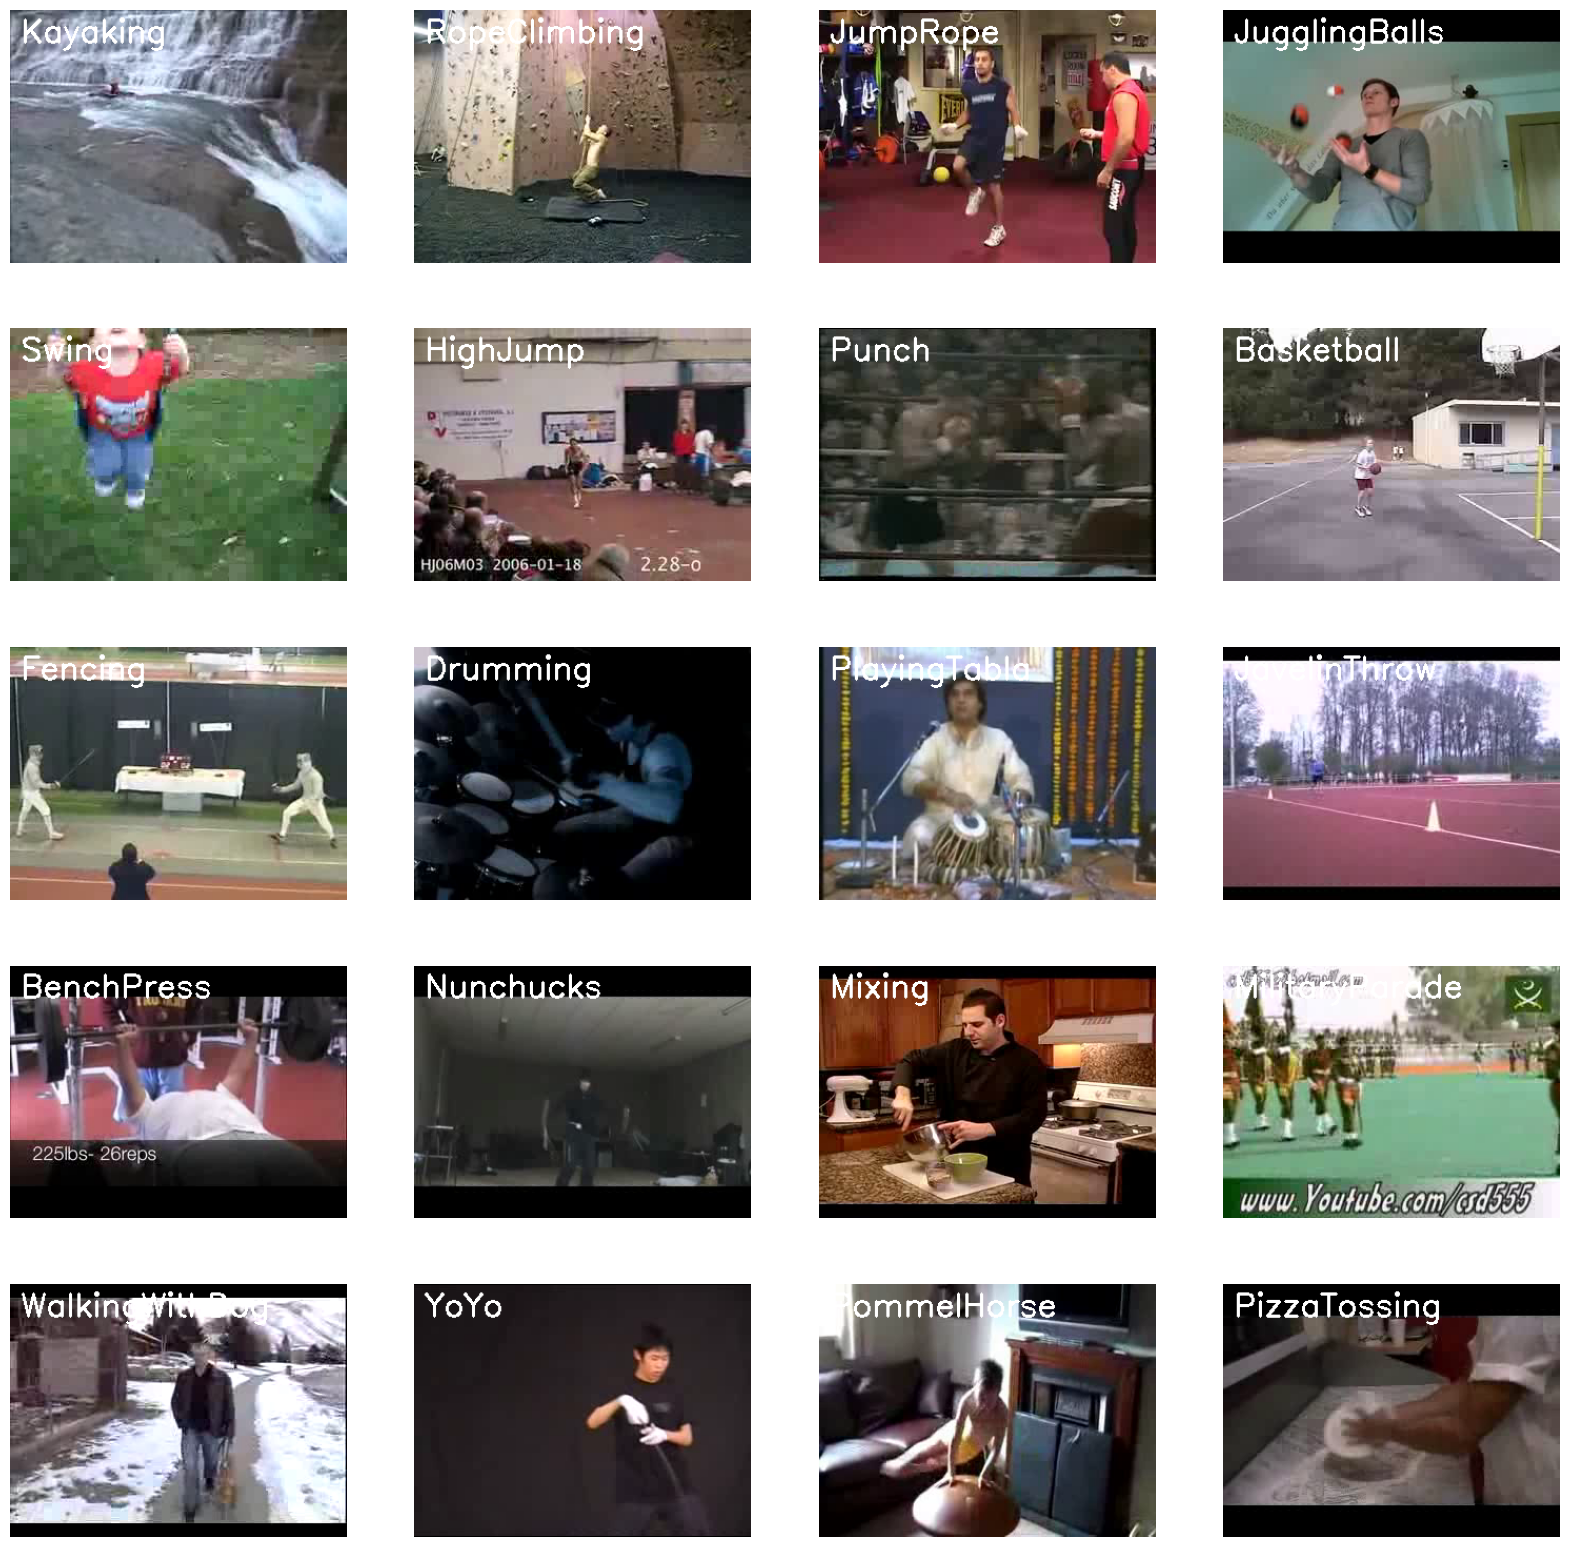

In [3]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('/kaggle/input/ucf50-action-recognition-dataset/UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'/kaggle/input/ucf50-action-recognition-dataset/UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'/kaggle/input/ucf50-action-recognition-dataset/UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [4]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 40

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/kaggle/input/ucf50-action-recognition-dataset/UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "Biking", "Swing", "Mixing","Punch","SoccerJuggling","JumpRope","Basketball"]

In [5]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [6]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [7]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: Biking
Extracting Data of Class: Swing
Extracting Data of Class: Mixing
Extracting Data of Class: Punch
Extracting Data of Class: SoccerJuggling
Extracting Data of Class: JumpRope
Extracting Data of Class: Basketball


In [8]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [9]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [10]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Functional Model for model construction.
    # Define the Model Architecture.
    ########################################################################################################################
    
    
    inputs=tf.keras.Input(shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,3))
    model=TimeDistributed(tf.keras.applications.MobileNet(weights="imagenet",include_top=False),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))(inputs)
    model=TimeDistributed(GlobalAveragePooling2D())(model)
    model=TimeDistributed(Dropout(0.3))(model)

    model=LSTM(128,return_sequences=True)(model)
    model=LSTM(32)(model)

    model=Dense(len(CLASSES_LIST), activation = 'softmax')(model)
    
    LRCN_model=tf.keras.Model(inputs=inputs,outputs=model)


    ########################################################################################################################

    # Display the models summary.
    LRCN_model.summary()

    # Return the constructed LRCN model.
    return LRCN_model

In [11]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 64, 64, 3)]   0         
                                                                 
 time_distributed (TimeDist  (None, 40, 2, 2, 1024)    3228864   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 40, 1024)          0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 40, 1024)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 40, 128)           590336    
                                                             

In [12]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min')

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'adamax', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 8 , shuffle = True, validation_split = 0.1, callbacks = [early_stopping_callback,reduce_lr_on_plateau])

Epoch 1/70
104/104 [==============================] - 31s 137ms/step - loss: 1.4004 - accuracy: 0.5418 - val_loss: 0.9328 - val_accuracy: 0.6848 - lr: 0.0010
Epoch 2/70
104/104 [==============================] - 12s 115ms/step - loss: 0.7505 - accuracy: 0.7988 - val_loss: 0.5506 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 3/70
104/104 [==============================] - 12s 115ms/step - loss: 0.4960 - accuracy: 0.8630 - val_loss: 0.3267 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 4/70
104/104 [==============================] - 12s 115ms/step - loss: 0.3982 - accuracy: 0.8958 - val_loss: 0.2383 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 5/70
104/104 [==============================] - 12s 115ms/step - loss: 0.2835 - accuracy: 0.9345 - val_loss: 0.2643 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 6/70
104/104 [==============================] - 12s 115ms/step - loss: 0.2581 - accuracy: 0.9345 - val_loss: 0.1894 - val_accuracy: 0.9674 - lr: 0.0010
Epoch 7/70
104/104 [==============================] 

In [13]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

8/8 [==============================] - 2s 118ms/step - loss: 0.1184 - accuracy: 0.9783


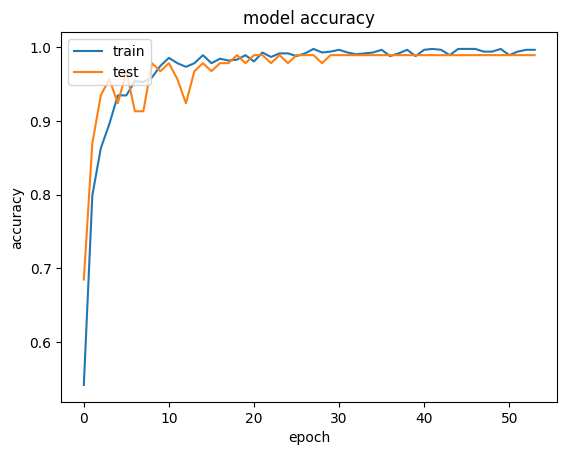

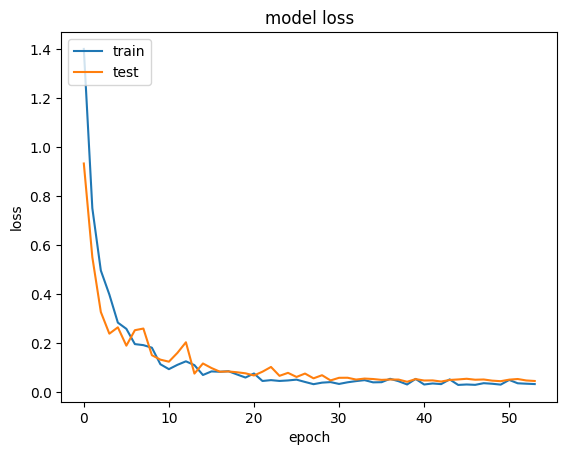

In [14]:
plt.plot(LRCN_model_training_history.history['accuracy'])
plt.plot(LRCN_model_training_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(LRCN_model_training_history.history['loss'])
plt.plot(LRCN_model_training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
LRCN_model.save("/kaggle/working/saved_model/")